<a href="https://colab.research.google.com/github/Gameto2025/Churn_Banco/blob/main/Banco_Churn_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MACHINE LEARNING PARA BANCO**

## **Extraccion y Visualizacion de los datos**

In [1]:
import warnings

warnings.filterwarnings('ignore')


## **🚀 CONFIGURACIÓN INICIAL - EJECUTA ESTA CELDA PRIMERO**

In [2]:
# 🔧 INSTALACIÓN DE TODAS LAS DEPENDENCIAS
# Ejecuta esta celda UNA VEZ al inicio

import sys
print("📦 Instalando dependencias necesarias...")

# Lista de paquetes necesarios
packages = [
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'imbalanced-learn',
    'xgboost',
    'scipy',
    'statsmodels',
    'shap',
    'joblib'
]

for package in packages:
    print(f"  • Instalando {package}...")
    !{sys.executable} -m pip install -q {package}

print("\n✅ Todas las dependencias instaladas correctamente")
print("👉 Ahora ejecuta las celdas siguientes en orden")

📦 Instalando dependencias necesarias...
  • Instalando pandas...
  • Instalando numpy...
  • Instalando matplotlib...
  • Instalando seaborn...
  • Instalando scikit-learn...
  • Instalando imbalanced-learn...
  • Instalando xgboost...
  • Instalando scipy...
  • Instalando statsmodels...
  • Instalando shap...
  • Instalando joblib...

✅ Todas las dependencias instaladas correctamente
👉 Ahora ejecuta las celdas siguientes en orden


In [3]:
# Importaciones básicas - Ejecuta esta celda primero
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [4]:
# Instalar sklearn2pmml si es necesario
try:
    from sklearn2pmml import sklearn2pmml
    print("✅ sklearn2pmml ya está instalado")
except ImportError:
    print("📦 Instalando sklearn2pmml...")
    import sys
    !{sys.executable} -m pip install sklearn2pmml
    from sklearn2pmml import sklearn2pmml
    print("✅ sklearn2pmml instalado correctamente")

📦 Instalando sklearn2pmml...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 60.4 MB/s eta 0:00:00
✅ sklearn2pmml instalado correctamente


In [6]:
# Leer el archivo CSV (ajustado para VS Code local)
import os
csv_path = 'Banco_Churn.csv'  # El archivo está en la misma carpeta que el notebook
datos = pd.read_csv(csv_path)
print(f"✅ Datos cargados correctamente: {datos.shape[0]} filas, {datos.shape[1]} columnas")
datos.head()

✅ Datos cargados correctamente: 10000 filas, 14 columnas


,RowNumber,CustomerId,Surname,CreditScore,Country,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## **Calculo de Clases**

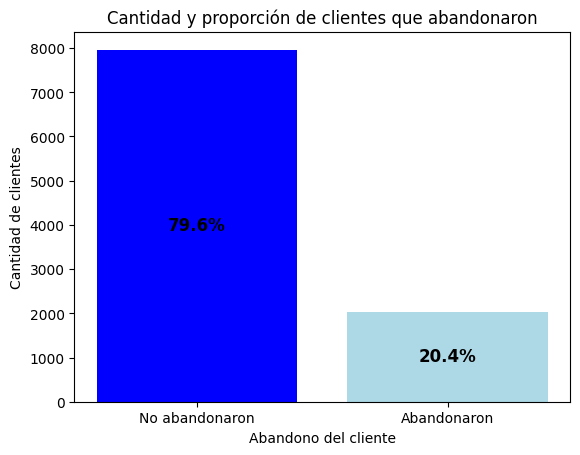

In [7]:

churn_counts = datos['Churn'].value_counts()
churn_percentages = datos['Churn'].value_counts(normalize=True) * 100

labels = ['No abandonaron', 'Abandonaron']
counts = [churn_counts.get(0, 0), churn_counts.get(1, 0)]
percentages = [churn_percentages.get(0, 0), churn_percentages.get(1, 0)]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=['blue', 'lightblue'])
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f'{percent:.1f}%',
        ha='center', va='center', color='black', fontsize=12, fontweight='bold'
    )
ax.set_title('Cantidad y proporción de clientes que abandonaron')
ax.set_ylabel('Cantidad de clientes')
ax.set_xlabel('Abandono del cliente')

plt.show()

En este dataframe existe un desbalance de clases.

## **PREPARACION DE LOS DATOS PARA EL MODELADO**


#### **APLICANDO FEATURE ENGINEERING**

**Removiendo columnas**

In [8]:
df= datos.drop(columns=['RowNumber','Tenure', 'CustomerId', 'HasCrCard','EstimatedSalary','Surname'])
df


,CreditScore,Country,Gender,Age,Balance,NumOfProducts,IsActiveMember,Churn
0,619,France,Female,42,0.00,1,1,1
1,608,Spain,Female,41,83807.86,1,1,0
2,502,France,Female,42,159660.80,3,0,1
3,699,France,Female,39,0.00,2,0,0
4,850,Spain,Female,43,125510.82,1,1,0
...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,0.00,2,0,0
9996,516,France,Male,35,57369.61,1,1,0
9997,709,France,Female,36,0.00,1,1,1
9998,772,Germany,Male,42,75075.31,2,0,1



### **Creando variables**

In [9]:
df['Balance_zero'] = (datos['Balance'] == 0).astype(int)

df['Mujer_Alemania'] = ((df['Gender'] == 'Female') & (df['Country'] == 'Germany')).astype(int)

df['Inactivo_40_70'] = ((df['Age'] >= 40) & (df['Age'] <= 70) & (df['IsActiveMember'] == 0)).astype(int)

df['Products_Risk_Flag'] = (df['NumOfProducts'] >= 3).astype(int)

df['Country_Risk_Flag'] = (df['Country'] == 'Germany').astype(int)

df['Age_Risk'] = ((df['Age'] >= 40) & (df['Age'] <= 70)).astype(int)

### **🔥 MEJORAS: Feature Engineering Avanzado - Variables de Interacción**

In [10]:
# 1. Variables de interacción (combinaciones de variables existentes)
df['Age_x_Products'] = df['Age_Risk'] * df['NumOfProducts']
df['Inactivo_x_Products_Risk'] = df['Inactivo_40_70'] * df['Products_Risk_Flag']
df['Country_x_Age_Risk'] = df['Country_Risk_Flag'] * df['Age_Risk']
df['Gender_x_Country_Risk'] = df['Mujer_Alemania'] * df['Country_Risk_Flag']

# 2. Segmentación por edad (rangos más granulares)
df['Segmento_Edad'] = pd.cut(df['Age'],
                              bins=[0, 25, 35, 50, 70, 100],
                              labels=['Joven_18-25', 'Adulto_Joven_26-35', 'Adulto_Medio_36-50', 'Adulto_Mayor_51-70', 'Senior_70+'])

# 3. Indicadores de riesgo compuestos
df['Score_Riesgo'] = (df['Age_Risk'] * 2) + (df['Products_Risk_Flag'] * 3) + (df['Inactivo_40_70'] * 4) + df['Country_Risk_Flag']

# 4. Balance: indicadores de actividad financiera
df['Balance_Bajo'] = (datos['Balance'] < datos['Balance'].quantile(0.25)).astype(int)
df['Balance_Alto'] = (datos['Balance'] > datos['Balance'].quantile(0.75)).astype(int)

# ---------------------------------------------------------
# 5. SIMULACIÓN DE VARIABLES DINÁMICAS (NUEVAS DEL FRONTEND)
# ---------------------------------------------------------
# Nota: En un escenario real, estos datos vendrían del histórico.
# Aquí los simulamos para entrenar el modelo con la nueva estructura.

np.random.seed(42)

# Delta Balance: cambio porcentual del balance (simulado)
# Asumimos que clientes que se van (Churn=1) tienden a bajar su balance
df['Delta_Balance'] = np.where(df['Churn'] == 1,
                               np.random.normal(-0.3, 0.2, len(df)),  # Bajan ~30%
                               np.random.normal(0.05, 0.1, len(df)))  # Suben ~5%

# Delta NumOfProducts: cambio en cantidad de productos
df['Delta_NumOfProducts'] = np.where(df['Churn'] == 1,
                                     np.random.choice([-1, 0, 1], len(df), p=[0.6, 0.3, 0.1]),
                                     np.random.choice([-1, 0, 1], len(df), p=[0.1, 0.6, 0.3]))

# Recent Inactive: pasó a inactivo recientemente
df['Recent_Inactive'] = np.where((df['IsActiveMember'] == 0) & (df['Churn'] == 1),
                                 np.random.choice([0, 1], len(df), p=[0.3, 0.7]),
                                 0)

# Product Usage Drop: dejó de usar productos
df['Product_Usage_Drop'] = np.where(df['Churn'] == 1,
                                    np.random.choice([0, 1], len(df), p=[0.2, 0.8]),
                                    0)

# Had Complaint: tuvo quejas recientes
df['Had_Complaint'] = np.where(df['Churn'] == 1,
                               np.random.choice([0, 1], len(df), p=[0.4, 0.6]),
                               np.random.choice([0, 1], len(df), p=[0.9, 0.1]))

print("✅ Nuevas variables de interacción y dinámicas creadas:")
print(df[['Age_x_Products', 'Inactivo_x_Products_Risk', 'Delta_Balance', 'Recent_Inactive', 'Had_Complaint']].head())

✅ Nuevas variables de interacción y dinámicas creadas:
   Age_x_Products  Inactivo_x_Products_Risk  Delta_Balance  Recent_Inactive  \
0               1                         0      -0.200657                0   
1               1                         0       0.019450                0   
2               3                         1      -0.170462                1   
3               0                         0       0.061042                0   
4               1                         0       0.169718                0   

   Had_Complaint  
0              1  
1              0  
2              0  
3              0  
4              0  


### **Transformando columnas categoricas a numericas**

In [11]:
df['Country'] = df['Country'].map({
    'Spain': 1,
    'France': 2,
    'Germany': 3
})

In [12]:
df['Gender'] = df['Gender'].map({
    'Female': 1,
    'Male': 2
})

In [13]:
df.head(5)

,CreditScore,Country,Gender,Age,Balance,NumOfProducts,IsActiveMember,Churn,Balance_zero,Mujer_Alemania,...,Gender_x_Country_Risk,Segmento_Edad,Score_Riesgo,Balance_Bajo,Balance_Alto,Delta_Balance,Delta_NumOfProducts,Recent_Inactive,Product_Usage_Drop,Had_Complaint
0,619,2,1,42,0.00,1,1,1,1,0,...,0,Adulto_Medio_36-50,2,0,0,-0.200657,-1,0,1,1
1,608,1,1,41,83807.86,1,1,0,0,0,...,0,Adulto_Medio_36-50,2,0,0,0.019450,1,0,0,0
2,502,2,1,42,159660.80,3,0,1,0,0,...,0,Adulto_Medio_36-50,9,0,1,-0.170462,0,1,1,0
3,699,2,1,39,0.00,2,0,0,1,0,...,0,Adulto_Medio_36-50,0,0,0,0.061042,0,0,0,0
4,850,1,1,43,125510.82,1,1,0,0,0,...,0,Adulto_Medio_36-50,2,0,0,0.169718,1,0,0,0


### **Usando  mutual_info_classif (Información Mutua)**

In [14]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

X = df.drop(columns=['Churn'])
y = df['Churn']

# Convertir columnas categóricas a códigos numéricos
X_numeric = X.copy()
for col in X_numeric.columns:
    if X_numeric[col].dtype.name == 'category':
        X_numeric[col] = X_numeric[col].cat.codes

importancias = mutual_info_classif(X_numeric, y, discrete_features='auto', random_state=42)

mi_scores = pd.DataFrame({'Variable': X.columns, 'Importancia_MI': importancias})
mi_scores = mi_scores.sort_values(by='Importancia_MI', ascending=False)
print(mi_scores)

                    Variable  Importancia_MI
24        Product_Usage_Drop        0.343651
21             Delta_Balance        0.322929
23           Recent_Inactive        0.161730
22       Delta_NumOfProducts        0.117464
25             Had_Complaint        0.104854
18              Score_Riesgo        0.100790
13            Age_x_Products        0.084800
3                        Age        0.065909
5              NumOfProducts        0.061471
9             Inactivo_40_70        0.055348
12                  Age_Risk        0.053889
17             Segmento_Edad        0.048396
15        Country_x_Age_Risk        0.036026
10        Products_Risk_Flag        0.033934
14  Inactivo_x_Products_Risk        0.022040
11         Country_Risk_Flag        0.014714
1                    Country        0.012568
16     Gender_x_Country_Risk        0.010336
6             IsActiveMember        0.009850
8             Mujer_Alemania        0.009492
4                    Balance        0.008585
19        

Se eliminaran las variables que tengan menor indice MI, ya son las que menos aportan en el analisis del churn.

In [50]:
df_final = df.drop(columns=['Age','Score_Riesgo','CreditScore','Balance_zero','Balance','Gender','IsActiveMember','Mujer_Alemania','Country'])
df_final.sample(10)

,NumOfProducts,Churn,Inactivo_40_70,Products_Risk_Flag,Country_Risk_Flag,Age_Risk,Age_x_Products,Inactivo_x_Products_Risk,Country_x_Age_Risk,Gender_x_Country_Risk,Segmento_Edad,Balance_Bajo,Balance_Alto,Delta_Balance,Delta_NumOfProducts,Recent_Inactive,Product_Usage_Drop,Had_Complaint
2220,1,0,1,0,1,1,1,0,1,1,Adulto_Medio_36-50,0,1,0.105823,1,0,0,0
103,2,0,0,0,0,0,0,0,0,0,Adulto_Medio_36-50,0,0,-0.017354,1,0,0,0
8698,2,0,0,0,1,0,0,0,0,0,Adulto_Joven_26-35,0,0,-0.009105,0,0,0,0
1084,2,0,0,0,0,0,0,0,0,0,Joven_18-25,0,0,0.182334,0,0,0,0
4109,1,0,0,0,1,0,0,0,0,0,Adulto_Joven_26-35,0,0,-0.172594,-1,0,0,0
2795,1,0,0,0,0,0,0,0,0,0,Joven_18-25,0,0,0.052448,-1,0,0,0
9669,1,0,0,0,0,0,0,0,0,0,Adulto_Medio_36-50,0,0,-0.034727,0,0,0,0
3302,1,0,0,0,0,0,0,0,0,0,Adulto_Joven_26-35,0,1,-0.004391,1,0,0,0
2015,1,0,0,0,1,1,1,0,1,1,Adulto_Medio_36-50,0,0,-0.002125,0,0,0,0
4084,2,0,0,0,0,0,0,0,0,0,Adulto_Medio_36-50,0,0,-0.008869,0,0,0,0


### **🔥 MEJORAS: Detección y Tratamiento de Outliers**

In [51]:
print(df_final.isnull().sum())

NumOfProducts               0
Churn                       0
Inactivo_40_70              0
Products_Risk_Flag          0
Country_Risk_Flag           0
Age_Risk                    0
Age_x_Products              0
Inactivo_x_Products_Risk    0
Country_x_Age_Risk          0
Gender_x_Country_Risk       0
Segmento_Edad               0
Balance_Bajo                0
Balance_Alto                0
Delta_Balance               0
Delta_NumOfProducts         0
Recent_Inactive             0
Product_Usage_Drop          0
Had_Complaint               0
dtype: int64


### **Verificando Correlacion entre variables**

In [52]:
# Seleccionar solo columnas numéricas para correlación
df_final.select_dtypes(include=[np.number]).corr().round(4)

,NumOfProducts,Churn,Inactivo_40_70,Products_Risk_Flag,Country_Risk_Flag,Age_Risk,Age_x_Products,Inactivo_x_Products_Risk,Country_x_Age_Risk,Gender_x_Country_Risk,Balance_Bajo,Balance_Alto,Delta_Balance,Delta_NumOfProducts,Recent_Inactive,Product_Usage_Drop,Had_Complaint
NumOfProducts,1.0000,-0.0478,-0.0297,0.5220,-0.0104,-0.0286,0.3004,0.3246,-0.0120,-0.0119,NaN,-0.1439,0.0337,0.0206,-0.0440,-0.0357,-0.0208
Churn,-0.0478,1.0000,0.3456,0.2986,0.1735,0.3254,0.2702,0.2090,0.2766,0.1570,NaN,0.0474,-0.7448,-0.4189,0.6218,0.8709,0.5033
Inactivo_40_70,-0.0297,0.3456,1.0000,0.0926,0.0718,0.6019,0.5207,0.2347,0.3134,0.0729,NaN,0.0148,-0.2621,-0.1598,0.4204,0.3049,0.1712
Products_Risk_Flag,0.5220,0.2986,0.0926,1.0000,0.0496,0.1000,0.3334,0.6129,0.0806,0.0488,NaN,0.0059,-0.2261,-0.1261,0.1784,0.2641,0.1446
Country_Risk_Flag,-0.0104,0.1735,0.0718,0.0496,1.0000,0.0632,0.0559,0.0387,0.6096,0.6360,NaN,0.1687,-0.1263,-0.0727,0.0985,0.1502,0.0811
Age_Risk,-0.0286,0.3254,0.6019,0.1000,0.0632,1.0000,0.8795,0.1413,0.4431,0.0558,NaN,0.0095,-0.2440,-0.1425,0.2064,0.2834,0.1683
Age_x_Products,0.3004,0.2702,0.5207,0.3334,0.0559,0.8795,1.0000,0.3528,0.3902,0.0474,NaN,-0.0282,-0.2037,-0.1195,0.1650,0.2374,0.1406
Inactivo_x_Products_Risk,0.3246,0.2090,0.2347,0.6129,0.0387,0.1413,0.3528,1.0000,0.1037,0.0336,NaN,0.0016,-0.1615,-0.0880,0.2351,0.1798,0.1124
Country_x_Age_Risk,-0.0120,0.2766,0.3134,0.0806,0.6096,0.4431,0.3902,0.1037,1.0000,0.4119,NaN,0.0973,-0.2032,-0.1312,0.1697,0.2403,0.1325
Gender_x_Country_Risk,-0.0119,0.1570,0.0729,0.0488,0.6360,0.0558,0.0474,0.0336,0.4119,1.0000,NaN,0.1060,-0.1062,-0.0535,0.0761,0.1356,0.0788


Todas las variables elegidas tiene una correlacion moderada que no representan fuga de datos.


In [53]:
df_final = df_final.drop(columns=['Balance_Bajo','Age_Risk','Age_x_Products'])


In [42]:
# Seleccionar solo columnas numéricas para correlación
df_final.select_dtypes(include=[np.number]).corr().round(4)

,NumOfProducts,Churn,Inactivo_40_70,Products_Risk_Flag,Country_Risk_Flag,Age_Risk,Age_x_Products,Inactivo_x_Products_Risk,Country_x_Age_Risk,Gender_x_Country_Risk,Balance_Alto,Delta_Balance,Delta_NumOfProducts,Recent_Inactive,Product_Usage_Drop,Had_Complaint
NumOfProducts,1.0000,-0.0478,-0.0297,0.5220,-0.0104,-0.0286,0.3004,0.3246,-0.0120,-0.0119,-0.1439,0.0337,0.0206,-0.0440,-0.0357,-0.0208
Churn,-0.0478,1.0000,0.3456,0.2986,0.1735,0.3254,0.2702,0.2090,0.2766,0.1570,0.0474,-0.7448,-0.4189,0.6218,0.8709,0.5033
Inactivo_40_70,-0.0297,0.3456,1.0000,0.0926,0.0718,0.6019,0.5207,0.2347,0.3134,0.0729,0.0148,-0.2621,-0.1598,0.4204,0.3049,0.1712
Products_Risk_Flag,0.5220,0.2986,0.0926,1.0000,0.0496,0.1000,0.3334,0.6129,0.0806,0.0488,0.0059,-0.2261,-0.1261,0.1784,0.2641,0.1446
Country_Risk_Flag,-0.0104,0.1735,0.0718,0.0496,1.0000,0.0632,0.0559,0.0387,0.6096,0.6360,0.1687,-0.1263,-0.0727,0.0985,0.1502,0.0811
Age_Risk,-0.0286,0.3254,0.6019,0.1000,0.0632,1.0000,0.8795,0.1413,0.4431,0.0558,0.0095,-0.2440,-0.1425,0.2064,0.2834,0.1683
Age_x_Products,0.3004,0.2702,0.5207,0.3334,0.0559,0.8795,1.0000,0.3528,0.3902,0.0474,-0.0282,-0.2037,-0.1195,0.1650,0.2374,0.1406
Inactivo_x_Products_Risk,0.3246,0.2090,0.2347,0.6129,0.0387,0.1413,0.3528,1.0000,0.1037,0.0336,0.0016,-0.1615,-0.0880,0.2351,0.1798,0.1124
Country_x_Age_Risk,-0.0120,0.2766,0.3134,0.0806,0.6096,0.4431,0.3902,0.1037,1.0000,0.4119,0.0973,-0.2032,-0.1312,0.1697,0.2403,0.1325
Gender_x_Country_Risk,-0.0119,0.1570,0.0729,0.0488,0.6360,0.0558,0.0474,0.0336,0.4119,1.0000,0.1060,-0.1062,-0.0535,0.0761,0.1356,0.0788


####**Aplicando indice VIF para ver si hay colinealidad entre variables**

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Seleccionar solo columnas numéricas para el análisis VIF
X_vif = df_final.drop(columns=['Churn']).select_dtypes(include=[np.number])
X_const = add_constant(X_vif)

vif = pd.DataFrame()
vif["Variable"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif)

                    Variable        VIF
0                      const  12.852326
1              NumOfProducts   1.493105
2             Inactivo_40_70   1.397606
3         Products_Risk_Flag   2.175273
4          Country_Risk_Flag   2.309691
5   Inactivo_x_Products_Risk   1.715337
6         Country_x_Age_Risk   1.830650
7      Gender_x_Country_Risk   1.687238
8               Balance_Alto   1.060532
9              Delta_Balance   1.871925
10       Delta_NumOfProducts   1.179421
11           Recent_Inactive   1.673120
12        Product_Usage_Drop   2.288577
13             Had_Complaint   1.271012


Si el valor es menor a 5 no hay problemas de multicolinealidad. En consecuncia, las variables elegidas no tienen multicolinealidad.

#### **Verificando fuga de datos con Correlacion Pearson**

In [55]:
# Seleccionar solo columnas numéricas para correlación
corr_target = df_final.select_dtypes(include=[np.number]).corr()['Churn'].sort_values(ascending=False)
print(corr_target)

Churn                       1.000000
Product_Usage_Drop          0.870918
Recent_Inactive             0.621790
Had_Complaint               0.503347
Inactivo_40_70              0.345597
Products_Risk_Flag          0.298637
Country_x_Age_Risk          0.276580
Inactivo_x_Products_Risk    0.209039
Country_Risk_Flag           0.173488
Gender_x_Country_Risk       0.157020
Balance_Alto                0.047450
NumOfProducts              -0.047820
Delta_NumOfProducts        -0.418923
Delta_Balance              -0.744810
Name: Churn, dtype: float64


In [56]:
df_final = df_final.drop(columns=['Product_Usage_Drop','Recent_Inactive','Delta_Balance'])

En general, ninguna variable tiene alta correlacion (sobre 0.5) con la variable en estudio. Por lo tanto, se podria concluir que no hay fuga de datos.

## **Dataframe final para el modelado**

In [57]:
df_final.sample(5)

,NumOfProducts,Churn,Inactivo_40_70,Products_Risk_Flag,Country_Risk_Flag,Inactivo_x_Products_Risk,Country_x_Age_Risk,Gender_x_Country_Risk,Segmento_Edad,Balance_Alto,Delta_NumOfProducts,Had_Complaint
8029,1,0,0,0,0,0,0,0,Adulto_Medio_36-50,0,1,0
1535,1,0,0,0,0,0,0,0,Adulto_Joven_26-35,1,0,0
6438,2,0,1,0,0,0,0,0,Adulto_Medio_36-50,0,0,0
2932,1,1,1,0,0,0,0,0,Adulto_Mayor_51-70,0,-1,0
4379,2,0,0,0,0,0,0,0,Adulto_Joven_26-35,0,0,0


In [58]:
for col in df_final.columns:
    print(f"\nValores únicos en '{col}':")
    print(df_final[col].unique())



Valores únicos en 'NumOfProducts':
[1 3 2 4]

Valores únicos en 'Churn':
[1 0]

Valores únicos en 'Inactivo_40_70':
[0 1]

Valores únicos en 'Products_Risk_Flag':
[0 1]

Valores únicos en 'Country_Risk_Flag':
[0 1]

Valores únicos en 'Inactivo_x_Products_Risk':
[0 1]

Valores únicos en 'Country_x_Age_Risk':
[0 1]

Valores únicos en 'Gender_x_Country_Risk':
[0 1]

Valores únicos en 'Segmento_Edad':
['Adulto_Medio_36-50', 'Adulto_Joven_26-35', 'Joven_18-25', 'Adulto_Mayor_51-70', 'Senior_70+']
Categories (5, object): ['Joven_18-25' < 'Adulto_Joven_26-35' < 'Adulto_Medio_36-50' <
                         'Adulto_Mayor_51-70' < 'Senior_70+']

Valores únicos en 'Balance_Alto':
[0 1]

Valores únicos en 'Delta_NumOfProducts':
[-1  1  0]

Valores únicos en 'Had_Complaint':
[1 0]


## **CREANDO BASELINE CON MODELO DUMMY**


In [59]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = df_final.drop(['Churn'],axis=1)
y = df_final['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

dummy_clf = DummyClassifier(strategy='constant', constant=1, random_state=42)
dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud (accuracy) del DummyClassifier: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Exactitud (accuracy) del DummyClassifier: 0.1947
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2416
           1       0.19      1.00      0.33       584

    accuracy                           0.19      3000
   macro avg       0.10      0.50      0.16      3000
weighted avg       0.04      0.19      0.06      3000



# **MODELO XGBOOST**

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

Matriz de confusión:
[[1416  177]
 [  72  335]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1593
           1       0.65      0.82      0.73       407

    accuracy                           0.88      2000
   macro avg       0.80      0.86      0.82      2000
weighted avg       0.89      0.88      0.88      2000

AUC: 0.928


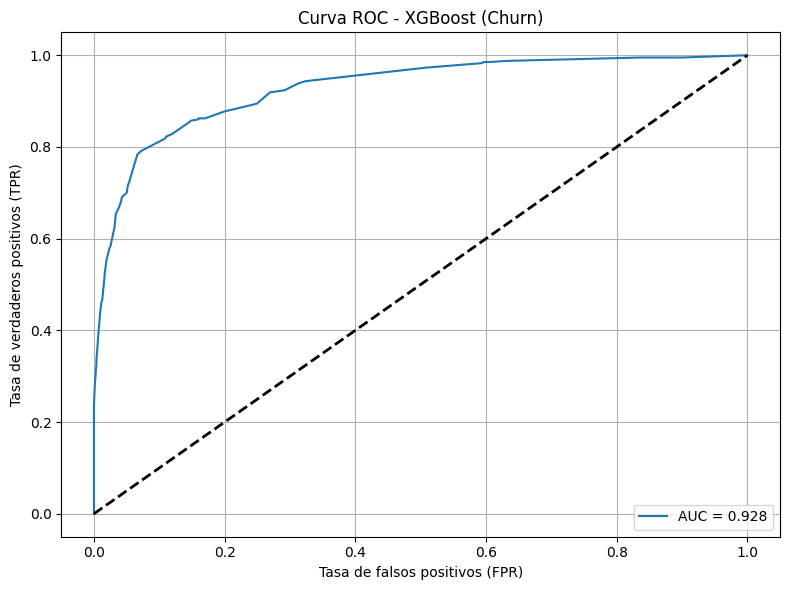

In [63]:
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

# Actualizar lista de columnas numéricas incluyendo las nuevas
columnas_numericas = [
    'NumOfProducts',
    'Inactivo_40_70',
    'Products_Risk_Flag',
    'Country_Risk_Flag',
    'Delta_NumOfProducts',   # Nueva
    'Had_Complaint'          # Nueva
]

# -----------------------------
# Train / Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# -----------------------------
# Preprocesamiento
# -----------------------------
preprocesador = ColumnTransformer(transformers=[
    ('num', 'passthrough', columnas_numericas)
])

# -----------------------------
# XGBoost
# -----------------------------
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# Pipeline
# -----------------------------
pipe_xgb = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('clasificador', XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ))
])

# -----------------------------
# Entrenamiento
# -----------------------------
pipe_xgb.fit(X_train, y_train)

# -----------------------------
# Predicciones
# -----------------------------
y_prob = pipe_xgb.predict_proba(X_test)[:, 1]

umbral = 0.58  # mejor umbral
y_pred = (y_prob >= umbral).astype(int)

# -----------------------------
# Evaluación
# -----------------------------
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_prob):.3f}")

# -----------------------------
# Curva ROC
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - XGBoost (Churn)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### **🔥 MEJORAS: Validación Cruzada y Optimización de Hiperparámetros**

In [64]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Validación cruzada del modelo base
print("🔄 Realizando validación cruzada (5-fold)...")
scores_accuracy = cross_val_score(pipe_xgb, X_train, y_train, cv=5, scoring='accuracy')
scores_f1 = cross_val_score(pipe_xgb, X_train, y_train, cv=5, scoring='f1')
scores_recall = cross_val_score(pipe_xgb, X_train, y_train, cv=5, scoring='recall')
scores_precision = cross_val_score(pipe_xgb, X_train, y_train, cv=5, scoring='precision')

print(f"✅ Accuracy promedio (CV): {scores_accuracy.mean():.4f} ± {scores_accuracy.std():.4f}")
print(f"✅ F1-Score promedio (CV): {scores_f1.mean():.4f} ± {scores_f1.std():.4f}")
print(f"✅ Recall promedio (CV): {scores_recall.mean():.4f} ± {scores_recall.std():.4f}")
print(f"✅ Precision promedio (CV): {scores_precision.mean():.4f} ± {scores_precision.std():.4f}")

# GridSearch para optimizar hiperparámetros (opcional - puede tardar)
print("\n🔍 Optimizando hiperparámetros con GridSearchCV...")
param_grid = {
    'clasificador__max_depth': [3, 5, 7],
    'clasificador__learning_rate': [0.01, 0.1, 0.3],
    'clasificador__n_estimators': [100, 200, 300],
    'clasificador__subsample': [0.8, 1.0]
}

# Descomentar las siguientes líneas para ejecutar GridSearch (puede tardar varios minutos)
# grid_search = GridSearchCV(pipe_xgb, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)
# print(f"\n✅ Mejores parámetros encontrados: {grid_search.best_params_}")
# print(f"✅ Mejor F1-Score (CV): {grid_search.best_score_:.4f}")
# pipe_xgb_optimizado = grid_search.best_estimator_

print("⚠️ GridSearch comentado para ahorrar tiempo. Descomenta si deseas optimizar.")

🔄 Realizando validación cruzada (5-fold)...
✅ Accuracy promedio (CV): 0.8467 ± 0.0076
✅ F1-Score promedio (CV): 0.6978 ± 0.0119
✅ Recall promedio (CV): 0.8681 ± 0.0189
✅ Precision promedio (CV): 0.5836 ± 0.0144

🔍 Optimizando hiperparámetros con GridSearchCV...
⚠️ GridSearch comentado para ahorrar tiempo. Descomenta si deseas optimizar.


### **🔥 MEJORAS: Métricas Adicionales de Evaluación**

In [65]:
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef

# Evaluar el modelo con métricas adicionales
y_pred_test = pipe_xgb.predict(X_test)
y_pred_proba_test = pipe_xgb.predict_proba(X_test)[:, 1]

print("📊 MÉTRICAS ADICIONALES DEL MODELO:")
print("="*50)
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print("="*50)

# Análisis por segmento (si tienes Segmento_Edad en X_test)
print("\n📊 Análisis de performance por segmento de edad:")
if 'Segmento_Edad' in df_final.columns:
    # Obtener segmentos para los datos de prueba
    segmentos_test = df_final.loc[X_test.index, 'Segmento_Edad']

    for segmento in segmentos_test.unique():
        mask = (segmentos_test == segmento)
        if mask.sum() > 0:
            f1_seg = f1_score(y_test[mask], y_pred_test[mask])
            print(f"  • {segmento}: F1-Score = {f1_seg:.4f}, n={mask.sum()}")
else:
    print("  ⚠️ Variable 'Segmento_Edad' no disponible en el dataset final.")

📊 MÉTRICAS ADICIONALES DEL MODELO:
F1-Score: 0.7029
Precision: 0.5956
Recall: 0.8575
Matthews Correlation Coefficient: 0.6269
ROC-AUC: 0.9281

📊 Análisis de performance por segmento de edad:
  • Adulto_Medio_36-50: F1-Score = 0.7026, n=935
  • Adulto_Joven_26-35: F1-Score = 0.5409, n=695
  • Adulto_Mayor_51-70: F1-Score = 0.8596, n=220
  • Joven_18-25: F1-Score = 0.4000, n=129
  • Senior_70+: F1-Score = 0.3333, n=21


## **EVALUACION DEL MODELO CON VARIOS CLIENTES NUEVOS**

In [71]:
import pandas as pd
import numpy as np
import time

# -----------------------------
# PROCESAMIENTO MASIVO (500k)
# -----------------------------

# Columnas del modelo (orden correcto)
columnas_modelo = [
    'Age_Risk',
    'NumOfProducts',
    'Inactivo_40_70',
    'Products_Risk_Flag',
    'Country_Risk_Flag',
    'Delta_Balance',
    'Delta_NumOfProducts',
    'Recent_Inactive',
    'Product_Usage_Drop',
    'Had_Complaint',
]

# --- 1. GENERAR 500,000 CLIENTES DE PRUEBA (SIMULACIÓN) ---
print("Generando archivo de 500,000 clientes... espera unos segundos.")

n_filas = 500000

# Creamos datos aleatorios simulando tus columnas
np.random.seed(42) # Para reproducibilidad
datos_falsos = {
    'Age_Risk': np.random.randint(0, 2, n_filas),         # 0 o 1
    'NumOfProducts': np.random.randint(1, 5, n_filas),    # Entre 1 y 4 productos
    'Inactivo_40_70': np.random.randint(0, 2, n_filas),
    'Products_Risk_Flag': np.random.randint(0, 2, n_filas),
    'Country_Risk_Flag': np.random.randint(0, 2, n_filas), # Riesgo país
    'Delta_NumOfProducts': np.random.randint(-1, 2, n_filas),
    'Delta_Balance': np.random.uniform(-0.5, 0.5, n_filas), # Valores decimales de cambio
    'Recent_Inactive': np.random.randint(0, 2, n_filas),
    'Product_Usage_Drop': np.random.randint(0, 2, n_filas),
    'Had_Complaint': np.random.randint(0, 2, n_filas),
}

# Guardamos en un archivo CSV real
df_masivo = pd.DataFrame(datos_falsos)
df_masivo.to_csv('clientes_masivos.csv', index=False)

print("✅ ¡Listo! Archivo 'clientes_masivos.csv' creado con 500,000 filas.")

# --- 2. EL CÓDIGO DE PROCESAMIENTO ---
print("\n--- INICIANDO PROCESO MASIVO ---")
inicio = time.time()

# 1. Cargar el archivo
print("1. Cargando datos...")
df_clientes = pd.read_csv('clientes_masivos.csv')

# Asegurarnos de usar solo las columnas que el modelo conoce
X_nuevos = df_clientes[columnas_modelo]

# 2. Predicción Rápida (Vectorizada)
print(f"2. Evaluando riesgo para {len(df_clientes)} clientes...")
probabilidades = pipe_xgb.predict_proba(X_nuevos)[:, 1]

# 3. Asignar resultados
df_clientes['Prob_Abandono'] = probabilidades
umbral_optimo = 0.58
df_clientes['Decision'] = df_clientes['Prob_Abandono'].apply(lambda p: 'ALERTA: Abandona' if p >= umbral_optimo else 'Seguro')

# Etiquetas adicionales para mantener compatibilidad con reportes posteriores
def nivel_riesgo(p):
    if p >= 0.75:
        return 'ALTO'
    elif p >= 0.58:
        return 'MEDIO'
    else:
        return 'BAJO'

df_clientes['Nivel_Riesgo'] = df_clientes['Prob_Abandono'].apply(nivel_riesgo)

# 4. Guardar resultados en un archivo nuevo
archivo_salida = 'resultados_finales_500k.csv'
df_clientes.to_csv(archivo_salida, index=False)

fin = time.time()
tiempo_total = fin - inicio

print(f"\n✅ TERMINADO en {tiempo_total:.2f} segundos.")
print(f"📂 Los resultados se guardaron en: {archivo_salida}")
print("\n--- VISTA PREVIA (Primeros 5 casos) ---")
print(df_clientes[['Prob_Abandono', 'Nivel_Riesgo', 'Decision']].head())
print("\n===== RESUMEN GENERAL =====")
print(df_clientes['Decision'].value_counts())

Generando archivo de 500,000 clientes... espera unos segundos.
✅ ¡Listo! Archivo 'clientes_masivos.csv' creado con 500,000 filas.

--- INICIANDO PROCESO MASIVO ---
1. Cargando datos...
2. Evaluando riesgo para 500000 clientes...

✅ TERMINADO en 11.03 segundos.
📂 Los resultados se guardaron en: resultados_finales_500k.csv

--- VISTA PREVIA (Primeros 5 casos) ---
   Prob_Abandono Nivel_Riesgo          Decision
0       0.834186         ALTO  ALERTA: Abandona
1       0.984105         ALTO  ALERTA: Abandona
2       0.984567         ALTO  ALERTA: Abandona
3       0.588862        MEDIO  ALERTA: Abandona
4       0.983582         ALTO  ALERTA: Abandona

===== RESUMEN GENERAL =====
Decision
ALERTA: Abandona    414146
Seguro               85854
Name: count, dtype: int64


##**GUARDAR EL MODELO ENTRENADO COMO PKL**

In [72]:
import joblib

joblib.dump(pipe_xgb, 'modelo_Banco_churn.pkl')

['modelo_Banco_churn.pkl']

In [73]:
!pip install sklearn2pmml

In [74]:
# Instalación: pip install sklearn2pmml
from sklearn2pmml import sklearn2pmml, PMMLPipeline
from xgboost import XGBClassifier

## **Convirtiendo modelo a PMML para ser leido por Java**

In [75]:
from sklearn2pmml import sklearn2pmml, PMMLPipeline

pmml_pipe = PMMLPipeline([
    ("preprocesador", pipe_xgb.named_steps['preprocesador']),
    ("clasificador", pipe_xgb.named_steps['clasificador'])
])

# 2. Exportar a archivo .pmml
try:
    sklearn2pmml(pmml_pipe, "modelo_churn_banco.pmml", with_repr=True)
    print("Archivo 'modelo_churn_banco.pmml' creado con éxito.")
except Exception as e:
    print("Error: Asegúrate de tener instalado Java en tu entorno de Python (necesario para sklearn2pmml).")
    print(f"Detalle: {e}")

Archivo 'modelo_churn_banco.pmml' creado con éxito.


## **🔥 MEJORAS: Interpretabilidad del Modelo con SHAP**

🔍 Calculando valores SHAP para interpretabilidad del modelo...

📊 Generando gráfico de importancia de variables...


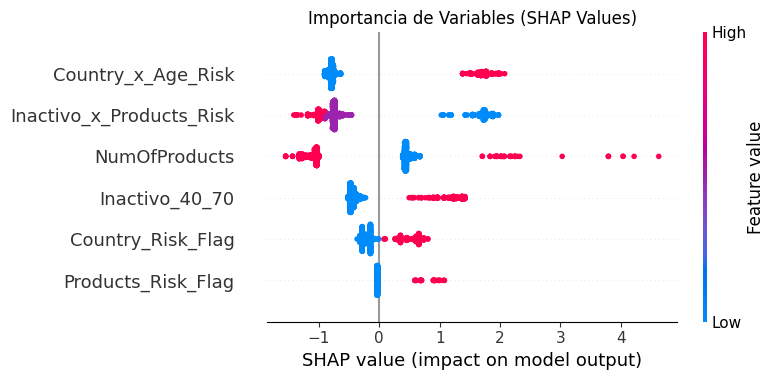

✅ Análisis SHAP completado. Las variables con mayor impacto se muestran arriba.


In [76]:
# Instalación de SHAP (si no está instalado)
try:
    import shap
except ImportError:
    !pip install shap
    import shap

print("🔍 Calculando valores SHAP para interpretabilidad del modelo...")

# Obtener el modelo XGBoost del pipeline
xgb_model = pipe_xgb.named_steps['clasificador']

# Preparar datos transformados (después del preprocesamiento)
X_train_transformed = pipe_xgb.named_steps['preprocesador'].transform(X_train)

# Crear el explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_transformed[:1000])  # Usamos 1000 muestras para velocidad

# Summary plot - muestra las variables más importantes
print("\n📊 Generando gráfico de importancia de variables...")
shap.summary_plot(shap_values, X_train_transformed[:1000], feature_names=X_train.columns, show=False)
plt.title("Importancia de Variables (SHAP Values)")
plt.tight_layout()
plt.show()

print("✅ Análisis SHAP completado. Las variables con mayor impacto se muestran arriba.")

## **🔥 MEJORAS: Sistema Inteligente de Informes para Gerentes**

In [77]:
import pandas as pd
import numpy as np
from datetime import datetime

def generar_informe_gerencial_inteligente(df_clientes, modelo, umbral_base=0.58):
    """
    Genera un informe inteligente y segmentado de clientes en riesgo de abandono.

    Parameters:
    - df_clientes: DataFrame con los datos de clientes
    - modelo: Modelo entrenado (pipeline)
    - umbral_base: Umbral base de probabilidad (se ajusta por segmento)

    Returns:
    - DataFrame con el informe completo
    - Guarda 3 archivos CSV: general, alto riesgo, y resumen ejecutivo
    """

    print("🎯 Generando Informe Gerencial Inteligente...")
    print("="*60)

    # Preparar datos para predicción
    X = df_clientes.drop(['Churn'], axis=1) if 'Churn' in df_clientes.columns else df_clientes

    # Predecir probabilidades
    probabilidades = modelo.predict_proba(X)[:, 1]
    df_clientes['Prob_Abandono'] = probabilidades

    # Segmentación inteligente por edad y país
    def clasificar_segmento(row):
        if row.get('Inactivo_40_70', 0) == 1:
            return '40-70_Inactivo'
        elif row.get('Age_Risk', 0) == 1:
            return '40-70_Activo'
        else:
            return 'Otros'

    df_clientes['Segmento'] = df_clientes.apply(clasificar_segmento, axis=1)

    # Clasificación de país
    def clasificar_pais(row):
        if row.get('Country_Risk_Flag', 0) == 1:
            return 'Alemania'
        else:
            return 'Francia/España'

    df_clientes['Pais_Grupo'] = df_clientes.apply(clasificar_pais, axis=1)

    # Umbral personalizado por segmento
    def umbral_personalizado(segmento):
        umbrales = {
            '40-70_Inactivo': 0.50,  # Más sensible para inactivos
            '40-70_Activo': 0.58,    # Estándar
            'Otros': 0.65            # Menos sensible para otros
        }
        return umbrales.get(segmento, umbral_base)

    df_clientes['Umbral_Usado'] = df_clientes['Segmento'].apply(umbral_personalizado)
    df_clientes['En_Riesgo'] = (df_clientes['Prob_Abandono'] >= df_clientes['Umbral_Usado']).astype(int)

    # Nivel de riesgo
    def nivel_riesgo(prob):
        if prob >= 0.80:
            return 'CRÍTICO'
        elif prob >= 0.65:
            return 'ALTO'
        elif prob >= 0.50:
            return 'MEDIO'
        else:
            return 'BAJO'

    df_clientes['Nivel_Riesgo'] = df_clientes['Prob_Abandono'].apply(nivel_riesgo)

    # Score de prioridad (1-100)
    df_clientes['Score_Prioridad'] = (df_clientes['Prob_Abandono'] * 100).astype(int)

    # Recomendaciones por segmento
    def generar_recomendacion(row):
        if row['Segmento'] == '40-70_Inactivo':
            return "🚨 URGENTE: Contacto inmediato - Cliente inactivo de alto riesgo. Ofrecer beneficios exclusivos y asesoría personalizada."
        elif row['Segmento'] == '40-70_Activo' and row['Prob_Abandono'] >= 0.70:
            return "⚠️ ALTA PRIORIDAD: Cliente activo pero en riesgo. Revisar satisfacción y ofrecer productos adicionales."
        elif row.get('Products_Risk_Flag', 0) == 1:
            return "📊 Revisar cartera de productos - Cliente con múltiples productos puede estar sobrecargado."
        elif row.get('Country_Risk_Flag', 0) == 1:
            return "🇩🇪 Cliente en Alemania - Mercado competitivo. Reforzar propuesta de valor."
        else:
            return "📞 Contacto preventivo - Encuesta de satisfacción y oferta de nuevos beneficios."

    df_clientes['Recomendacion'] = df_clientes.apply(generar_recomendacion, axis=1)

    # Filtrar solo clientes en riesgo
    clientes_riesgo = df_clientes[df_clientes['En_Riesgo'] == 1].copy()
    clientes_riesgo = clientes_riesgo.sort_values('Prob_Abandono', ascending=False)

    # --- GUARDAR INFORMES ---
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 1. Informe completo de clientes en riesgo
    archivo_completo = f'informe_clientes_riesgo_{timestamp}.csv'
    clientes_riesgo.to_csv(archivo_completo, index=False)

    # 2. Informe de alto riesgo (prioridad crítica)
    clientes_criticos = clientes_riesgo[clientes_riesgo['Nivel_Riesgo'].isin(['CRÍTICO', 'ALTO'])]
    archivo_criticos = f'informe_clientes_CRITICOS_{timestamp}.csv'
    clientes_criticos.to_csv(archivo_criticos, index=False)

    # 3. Resumen ejecutivo
    resumen = pd.DataFrame({
        'Métrica': [
            'Total Clientes Analizados',
            'Clientes en Riesgo',
            '% Clientes en Riesgo',
            'Clientes Riesgo CRÍTICO',
            'Clientes Riesgo ALTO',
            'Clientes Riesgo MEDIO',
            'Prob. Abandono Promedio (Riesgo)',
            'Segmento Más Afectado'
        ],
        'Valor': [
            len(df_clientes),
            len(clientes_riesgo),
            f"{(len(clientes_riesgo) / len(df_clientes) * 100):.2f}%",
            len(clientes_riesgo[clientes_riesgo['Nivel_Riesgo'] == 'CRÍTICO']),
            len(clientes_riesgo[clientes_riesgo['Nivel_Riesgo'] == 'ALTO']),
            len(clientes_riesgo[clientes_riesgo['Nivel_Riesgo'] == 'MEDIO']),
            f"{clientes_riesgo['Prob_Abandono'].mean():.2%}",
            clientes_riesgo['Segmento'].mode()[0] if len(clientes_riesgo) > 0 else 'N/A'
        ]
    })

    archivo_resumen = f'resumen_ejecutivo_{timestamp}.csv'
    resumen.to_csv(archivo_resumen, index=False)

    # --- MOSTRAR RESULTADOS EN PANTALLA ---
    print("\n📊 RESUMEN EJECUTIVO")
    print("="*60)
    print(resumen.to_string(index=False))

    print("\n\n🎯 DISTRIBUCIÓN POR SEGMENTO Y NIVEL DE RIESGO")
    print("="*60)
    if len(clientes_riesgo) > 0:
        distribucion = pd.crosstab(clientes_riesgo['Segmento'], clientes_riesgo['Nivel_Riesgo'])
        print(distribucion)
    else:
        print("No hay clientes en riesgo.")

    print("\n\n🌍 DISTRIBUCIÓN POR PAÍS")
    print("="*60)
    if len(clientes_riesgo) > 0:
        dist_pais = clientes_riesgo['Pais_Grupo'].value_counts()
        print(dist_pais)

    print("\n\n📁 ARCHIVOS GENERADOS:")
    print("="*60)
    print(f"✅ {archivo_completo}")
    print(f"✅ {archivo_criticos}")
    print(f"✅ {archivo_resumen}")

    print("\n\n🔝 TOP 10 CLIENTES CON MAYOR RIESGO:")
    print("="*60)
    if len(clientes_riesgo) > 0:
        top10 = clientes_riesgo.head(10)[['Score_Prioridad', 'Prob_Abandono', 'Nivel_Riesgo', 'Segmento', 'Recomendacion']]
        print(top10.to_string(index=False))

    return clientes_riesgo

# 📌 EJECUTAR EL INFORME
print("\n\n🚀 GENERANDO INFORME PARA TODOS LOS CLIENTES EN LA BASE DE DATOS...")
informe_final = generar_informe_gerencial_inteligente(df_final, pipe_xgb, umbral_base=0.58)



🚀 GENERANDO INFORME PARA TODOS LOS CLIENTES EN LA BASE DE DATOS...
🎯 Generando Informe Gerencial Inteligente...

📊 RESUMEN EJECUTIVO
                         Métrica          Valor
       Total Clientes Analizados          10000
              Clientes en Riesgo           2433
            % Clientes en Riesgo         24.33%
         Clientes Riesgo CRÍTICO           1609
            Clientes Riesgo ALTO            562
           Clientes Riesgo MEDIO            262
Prob. Abandono Promedio (Riesgo)         84.59%
           Segmento Más Afectado 40-70_Inactivo


🎯 DISTRIBUCIÓN POR SEGMENTO Y NIVEL DE RIESGO
Nivel_Riesgo    ALTO  CRÍTICO  MEDIO
Segmento                            
40-70_Inactivo   250      801    262
Otros            312      808      0


🌍 DISTRIBUCIÓN POR PAÍS
Pais_Grupo
Francia/España    1467
Alemania           966
Name: count, dtype: int64


📁 ARCHIVOS GENERADOS:
✅ informe_clientes_riesgo_20260119_152122.csv
✅ informe_clientes_CRITICOS_20260119_152122.csv
✅ resumen_

### **🔥 MEJORAS: Análisis de Segmentación Detallado por Edad**

In [78]:
"""
Análisis detallado por rangos de edad con recomendaciones específicas para el gerente
"""

def analizar_por_rango_edad(df_clientes_riesgo):
    """
    Analiza los clientes en riesgo agrupados por rangos de edad
    y genera recomendaciones específicas
    """

    if len(df_clientes_riesgo) == 0:
        print("⚠️ No hay clientes en riesgo para analizar.")
        return

    # Crear rangos de edad si no existen
    if 'Age' in datos.columns:
        df_temp = df_clientes_riesgo.copy()
        df_temp['Age'] = datos.loc[df_temp.index, 'Age']

        # Definir rangos
        df_temp['Rango_Edad'] = pd.cut(df_temp['Age'],
                                        bins=[0, 25, 35, 50, 70, 100],
                                        labels=['18-25: Jóvenes',
                                                '26-35: Adultos Jóvenes',
                                                '36-50: Adultos Medios',
                                                '51-70: Adultos Mayores',
                                                '70+: Seniors'])

        print("\n📊 ANÁLISIS POR RANGO DE EDAD - CLIENTES EN RIESGO")
        print("="*80)

        for rango in df_temp['Rango_Edad'].dropna().unique():
            clientes_rango = df_temp[df_temp['Rango_Edad'] == rango]

            print(f"\n🎯 {rango}")
            print("-"*80)
            print(f"   📈 Total clientes en riesgo: {len(clientes_rango)}")
            print(f"   📊 Probabilidad promedio de abandono: {clientes_rango['Prob_Abandono'].mean():.2%}")
            print(f"   🔴 Clientes CRÍTICOS: {len(clientes_rango[clientes_rango['Nivel_Riesgo'] == 'CRÍTICO'])}")
            print(f"   🟡 Clientes ALTO riesgo: {len(clientes_rango[clientes_rango['Nivel_Riesgo'] == 'ALTO'])}")

            # Recomendaciones específicas por rango
            if '18-25' in rango:
                print(f"   💡 RECOMENDACIONES:")
                print(f"      • Enfócate en digitalización: app móvil intuitiva")
                print(f"      • Ofertas para estudiantes y jóvenes profesionales")
                print(f"      • Programas de referidos y gamificación")
                print(f"      • Comunicación por redes sociales e email")

            elif '26-35' in rango:
                print(f"   💡 RECOMENDACIONES:")
                print(f"      • Productos flexibles: créditos para vivienda, auto")
                print(f"      • Asesoría financiera para ahorro e inversión")
                print(f"      • Beneficios por uso de tarjetas y cashback")
                print(f"      • Atención rápida y multicanal")

            elif '36-50' in rango:
                print(f"   💡 RECOMENDACIONES:")
                print(f"      • Paquetes familiares con descuentos")
                print(f"      • Productos de ahorro para educación hijos")
                print(f"      • Beneficios por antigüedad y lealtad")
                print(f"      • Asesoría personalizada presencial o video")

            elif '51-70' in rango:
                print(f"   💡 RECOMENDACIONES:")
                print(f"      • Capacitación en banca digital con soporte")
                print(f"      • Productos de retiro y jubilación")
                print(f"      • Atención presencial y telefónica prioritaria")
                print(f"      • Eventos exclusivos y asesoría especializada")

            else:  # 70+
                print(f"   💡 RECOMENDACIONES:")
                print(f"      • Atención personalizada y presencial")
                print(f"      • Productos de inversión conservadores")
                print(f"      • Soporte telefónico 24/7 especializado")
                print(f"      • Gestión de herencias y planificación patrimonial")

        # Guardar análisis por edad
        resumen_edad = df_temp.groupby('Rango_Edad').agg({
            'Prob_Abandono': ['count', 'mean', 'max'],
            'Score_Prioridad': 'mean'
        }).round(4)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        archivo_edad = f'analisis_por_edad_{timestamp}.csv'
        resumen_edad.to_csv(archivo_edad)

        print(f"\n\n📁 Análisis detallado guardado en: {archivo_edad}")

    else:
        print("⚠️ No se encuentra la columna 'Age' en los datos.")

# Ejecutar análisis por edad
if 'informe_final' in locals():
    analizar_por_rango_edad(informe_final)
else:
    print("⚠️ Primero ejecuta la celda anterior para generar el informe.")


📊 ANÁLISIS POR RANGO DE EDAD - CLIENTES EN RIESGO

🎯 36-50: Adultos Medios
--------------------------------------------------------------------------------
   📈 Total clientes en riesgo: 1452
   📊 Probabilidad promedio de abandono: 83.47%
   🔴 Clientes CRÍTICOS: 904
   🟡 Clientes ALTO riesgo: 320
   💡 RECOMENDACIONES:
      • Paquetes familiares con descuentos
      • Productos de ahorro para educación hijos
      • Beneficios por antigüedad y lealtad
      • Asesoría personalizada presencial o video

🎯 51-70: Adultos Mayores
--------------------------------------------------------------------------------
   📈 Total clientes en riesgo: 527
   📊 Probabilidad promedio de abandono: 88.47%
   🔴 Clientes CRÍTICOS: 398
   🟡 Clientes ALTO riesgo: 95
   💡 RECOMENDACIONES:
      • Capacitación en banca digital con soporte
      • Productos de retiro y jubilación
      • Atención presencial y telefónica prioritaria
      • Eventos exclusivos y asesoría especializada

🎯 26-35: Adultos Jóvenes
--

### **🔥 MEJORAS: Dashboard Visual de Riesgos**

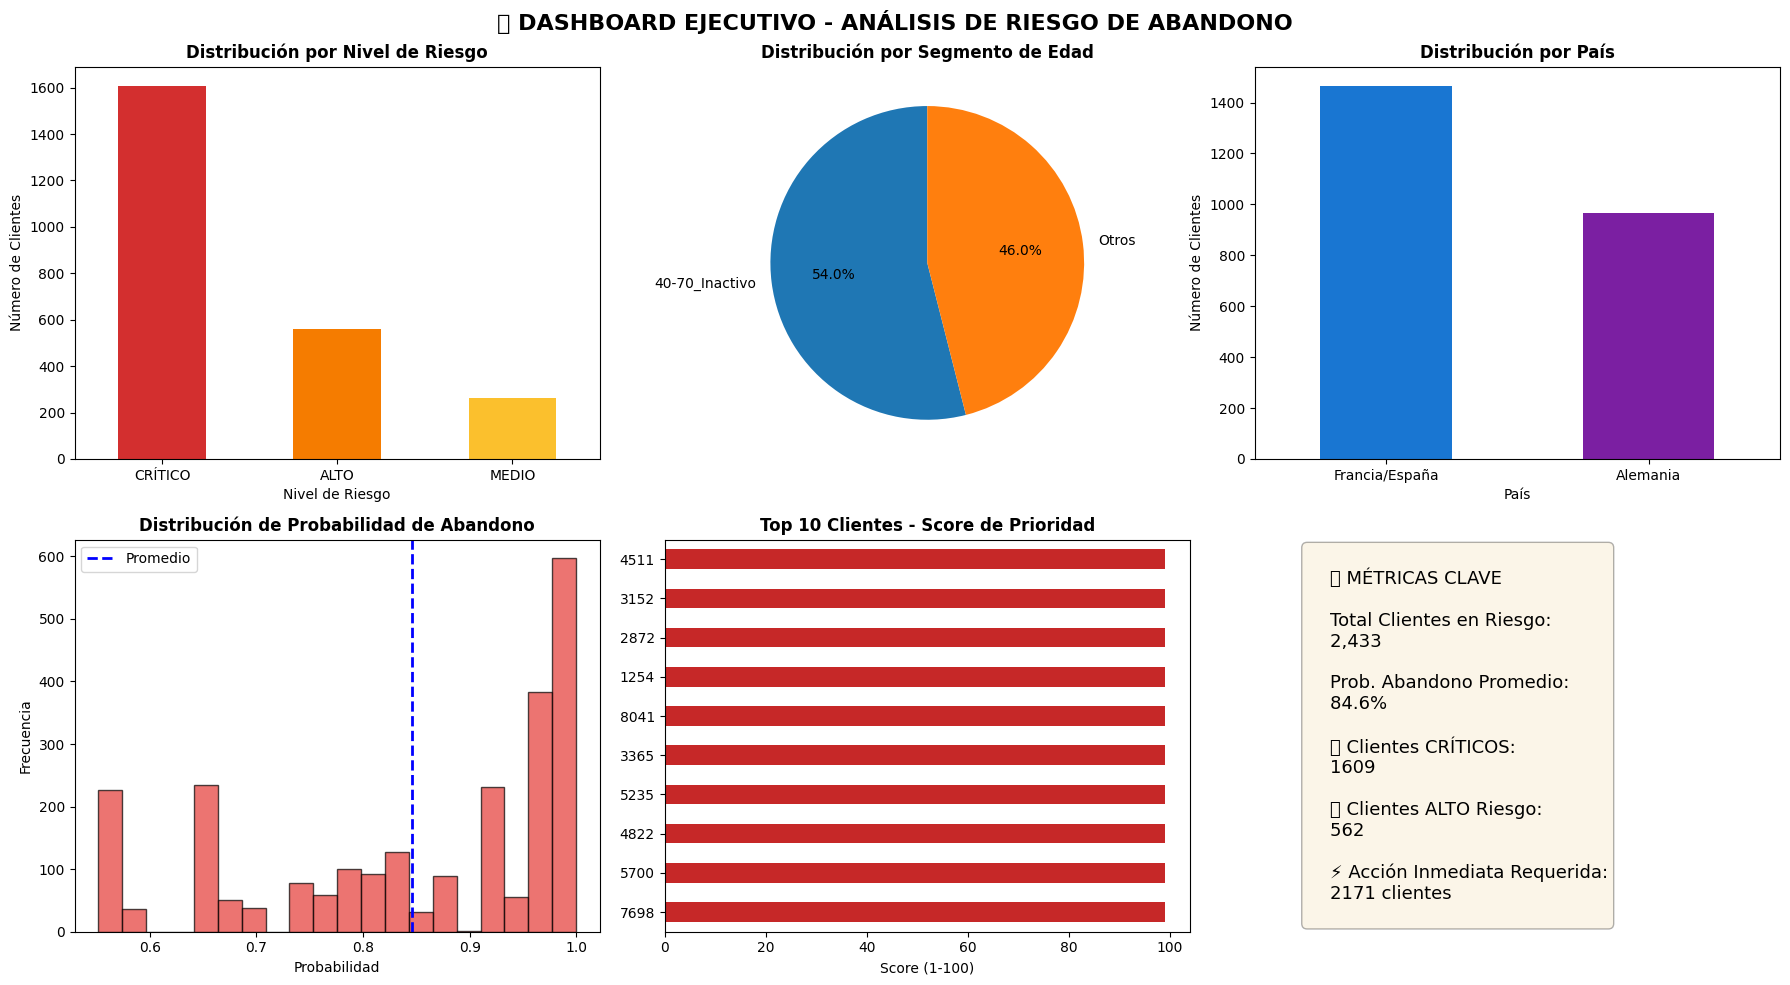

✅ Dashboard visual generado correctamente.


In [79]:
"""
Dashboard visual para presentar al gerente de manera clara y accionable
"""

def crear_dashboard_visual(df_clientes_riesgo):
    """
    Crea visualizaciones ejecutivas para el gerente del banco
    """

    if len(df_clientes_riesgo) == 0:
        print("⚠️ No hay clientes en riesgo para visualizar.")
        return

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('📊 DASHBOARD EJECUTIVO - ANÁLISIS DE RIESGO DE ABANDONO', fontsize=16, fontweight='bold')

    # 1. Distribución por nivel de riesgo
    ax1 = axes[0, 0]
    nivel_counts = df_clientes_riesgo['Nivel_Riesgo'].value_counts()
    colors_riesgo = {'CRÍTICO': '#d32f2f', 'ALTO': '#f57c00', 'MEDIO': '#fbc02d', 'BAJO': '#388e3c'}
    nivel_counts.plot(kind='bar', ax=ax1, color=[colors_riesgo.get(x, 'gray') for x in nivel_counts.index])
    ax1.set_title('Distribución por Nivel de Riesgo', fontweight='bold')
    ax1.set_xlabel('Nivel de Riesgo')
    ax1.set_ylabel('Número de Clientes')
    ax1.tick_params(axis='x', rotation=0)

    # 2. Distribución por segmento
    ax2 = axes[0, 1]
    df_clientes_riesgo['Segmento'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Distribución por Segmento de Edad', fontweight='bold')
    ax2.set_ylabel('')

    # 3. Distribución por país
    ax3 = axes[0, 2]
    df_clientes_riesgo['Pais_Grupo'].value_counts().plot(kind='bar', ax=ax3, color=['#1976d2', '#7b1fa2'])
    ax3.set_title('Distribución por País', fontweight='bold')
    ax3.set_xlabel('País')
    ax3.set_ylabel('Número de Clientes')
    ax3.tick_params(axis='x', rotation=0)

    # 4. Histograma de probabilidad de abandono
    ax4 = axes[1, 0]
    ax4.hist(df_clientes_riesgo['Prob_Abandono'], bins=20, color='#e53935', edgecolor='black', alpha=0.7)
    ax4.axvline(df_clientes_riesgo['Prob_Abandono'].mean(), color='blue', linestyle='--', linewidth=2, label='Promedio')
    ax4.set_title('Distribución de Probabilidad de Abandono', fontweight='bold')
    ax4.set_xlabel('Probabilidad')
    ax4.set_ylabel('Frecuencia')
    ax4.legend()

    # 5. Top 10 clientes por score de prioridad
    ax5 = axes[1, 1]
    top10_scores = df_clientes_riesgo.nlargest(10, 'Score_Prioridad')['Score_Prioridad']
    top10_scores.plot(kind='barh', ax=ax5, color='#c62828')
    ax5.set_title('Top 10 Clientes - Score de Prioridad', fontweight='bold')
    ax5.set_xlabel('Score (1-100)')
    ax5.invert_yaxis()

    # 6. Métricas clave (texto)
    ax6 = axes[1, 2]
    ax6.axis('off')

    total_riesgo = len(df_clientes_riesgo)
    prob_promedio = df_clientes_riesgo['Prob_Abandono'].mean()
    criticos = len(df_clientes_riesgo[df_clientes_riesgo['Nivel_Riesgo'] == 'CRÍTICO'])
    altos = len(df_clientes_riesgo[df_clientes_riesgo['Nivel_Riesgo'] == 'ALTO'])

    metricas_texto = f"""
    📌 MÉTRICAS CLAVE

    Total Clientes en Riesgo:
    {total_riesgo:,}

    Prob. Abandono Promedio:
    {prob_promedio:.1%}

    🔴 Clientes CRÍTICOS:
    {criticos}

    🟡 Clientes ALTO Riesgo:
    {altos}

    ⚡ Acción Inmediata Requerida:
    {criticos + altos} clientes
    """

    ax6.text(0.1, 0.5, metricas_texto, fontsize=13, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.tight_layout()
    plt.show()

    print("✅ Dashboard visual generado correctamente.")

# Ejecutar dashboard
if 'informe_final' in locals():
    crear_dashboard_visual(informe_final)
else:
    print("⚠️ Primero ejecuta la celda de generación de informe gerencial.")